# Тестовое задание на позицию аналитика данных (middle) Welltory

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data_for_test.csv')
data = df.copy()
df.head()

,time_start_local,time_end_local,time_offset,steps
0,2022-03-19 01:21:58,2022-03-19 01:22:00,3600,2
1,2022-03-19 01:21:58,2022-03-19 01:22:00,3600,2
2,2022-03-19 04:52:50,2022-03-19 04:52:55,3600,6
3,2022-03-19 04:52:55,2022-03-19 04:52:50,3600,6
4,2022-03-19 04:52:55,2022-03-19 04:52:50,3600,6


В первых 5 строках датасета уже видны некоторые проблемы с данными:
- есть дубли
- есть строки, где время окончания записи меньше времени начала.

Кроме того удалим столбец time_offset, который содержит данные о смещении локального времени относительно UTC - разницу в секундах между универсальным скоординированным временем и местным солнечным временем в местности пользователя. Он довольно бесполезен в задании, т.к. нам надо считать разность по времени для каждой строки данных.

In [3]:
df.dtypes

time_start_local    object
time_end_local      object
time_offset          int64
steps                int64
dtype: object

Столбцы time_start_local и time_end_local нужно из типа объект сделать datetime

In [4]:
df.drop(columns=['time_offset'], inplace = True)
df.drop_duplicates(inplace=True)
# изменяем тип столбцов с датами на datetime
df['time_start_local'] = pd.to_datetime(df['time_start_local'])
df['time_end_local'] = pd.to_datetime(df['time_end_local'])
# рассчитываем продолжительность записи
df['duration'] = df['time_end_local'] - df['time_start_local']

# Исследуем данные на дубликаты, пересекающиеся и вложенные данные, записи, которые можно объединить

Проверим, не являются ли строки с обратной записью времени дублями строк с нормальной записью времени 

In [5]:
df1 = df.copy()
df2 = df1[df1['duration']<pd.Timedelta(0)]
df3 = df1.merge(df2, left_on=['time_start_local', 'time_end_local'],
               right_on=['time_end_local', 'time_start_local'])
print(f'Количество данных с обратным порядком записи времени: {df2.shape[0]},\nиз них совпадает с данными с нормальной записью времени: {df3.shape[0]}')
del df1, df2, df3

Количество данных с обратным порядком записи времени: 500,
из них совпадает с данными с нормальной записью времени: 500


В df3 попали только те записи, для которых есть соответствие обоих ключей time_start_local, time_end_local, при условии, что они поменяны местами (т.о. мы искали полные дубли). Поскольку df1 был предварительно очищен от дублей, то совпадение количества данных с обратным порядком записи времени с количеством данных-дублей из df3, говорит о том, что данные с обратным порядком записи времени являются в полном объеме дубликатами и от них можно избавиться.

In [6]:
df = df[df['duration']>pd.Timedelta(0)]
df.head()

,time_start_local,time_end_local,steps,duration
0,2022-03-19 01:21:58,2022-03-19 01:22:00,2,0 days 00:00:02
2,2022-03-19 04:52:50,2022-03-19 04:52:55,6,0 days 00:00:05
5,2022-03-19 07:55:35,2022-03-19 07:55:40,6,0 days 00:00:05
6,2022-03-19 08:15:33,2022-03-19 08:25:34,143,0 days 00:10:01
7,2022-03-19 08:25:34,2022-03-19 08:26:05,13,0 days 00:00:31


In [7]:
# Отсортируем данные по времени начала записи
df.sort_values(by=['time_start_local'], inplace = True)
df.head()

,time_start_local,time_end_local,steps,duration
0,2022-03-19 01:21:58,2022-03-19 01:22:00,2,0 days 00:00:02
2,2022-03-19 04:52:50,2022-03-19 04:52:55,6,0 days 00:00:05
5,2022-03-19 07:55:35,2022-03-19 07:55:40,6,0 days 00:00:05
6,2022-03-19 08:15:33,2022-03-19 08:25:34,143,0 days 00:10:01
7,2022-03-19 08:25:34,2022-03-19 08:26:05,13,0 days 00:00:31


Окончание записи с индексом 6 совпадает со стартом следующей записи. Такие записи следует объединять, поскольку это непрерывная хотьба.

In [8]:
merged = 1
while merged != 0:
    df = df.merge(df, how = 'left', left_on=['time_end_local'],
                   right_on=['time_start_local'])
    df.rename(columns={'time_start_local_x':'time_start_local', 
                        'time_end_local_x':'time_end_local',
                        'steps_x': 'steps',
                        'duration_x':'duration'}, inplace=True)
    df['steps'][df['time_start_local_y'].notna()]=df['steps'][df['time_start_local_y'].notna()] \
        + df['steps_y'][df['time_start_local_y'].notna()]

    df['duration'][df['time_start_local_y'].notna()]=df['duration'][df['time_start_local_y'].notna()] \
        + df['duration_y'][df['time_start_local_y'].notna()]

    df['time_end_local'][df['time_start_local_y'].notna()]=\
        df['time_end_local_y'][df['time_start_local_y'].notna()]
    merged = len(df['time_end_local_y'][df['time_start_local_y'].notna()])

    df.drop(columns=['time_start_local_y', 'time_end_local_y','steps_y', 'duration_y'], inplace = True) 
df.head()

,time_start_local,time_end_local,steps,duration
0,2022-03-19 01:21:58,2022-03-19 01:22:00,2,0 days 00:00:02
1,2022-03-19 04:52:50,2022-03-19 04:52:55,6,0 days 00:00:05
2,2022-03-19 07:55:35,2022-03-19 07:55:40,6,0 days 00:00:05
3,2022-03-19 08:15:33,2022-03-19 08:26:05,156,0 days 00:10:32
4,2022-03-19 08:25:34,2022-03-19 08:26:05,13,0 days 00:00:31


В последних двух строчках можно заметить, что  строка с индексом 3 включает в себя время измерения строки с индексом 4. Уберем из датафрейма вложенные данные.

In [9]:
for i, d in df.iterrows():
    parrent_int = df[(df['time_start_local']<=d.time_start_local)&(df['time_end_local']>=d.time_end_local)]
    if len(parrent_int) > 1:
        df.drop([i], inplace = True)    
del parrent_int        
df.head(10)

,time_start_local,time_end_local,steps,duration
0,2022-03-19 01:21:58,2022-03-19 01:22:00,2,0 days 00:00:02
1,2022-03-19 04:52:50,2022-03-19 04:52:55,6,0 days 00:00:05
2,2022-03-19 07:55:35,2022-03-19 07:55:40,6,0 days 00:00:05
3,2022-03-19 08:15:33,2022-03-19 08:26:05,156,0 days 00:10:32
5,2022-03-19 12:16:18,2022-03-19 12:16:39,25,0 days 00:00:21
6,2022-03-19 12:17:22,2022-03-19 12:17:27,13,0 days 00:00:05
7,2022-03-19 12:18:34,2022-03-19 12:18:52,38,0 days 00:00:18
8,2022-03-19 12:18:55,2022-03-19 12:28:14,19,0 days 00:09:19
9,2022-03-19 12:31:34,2022-03-19 12:32:10,27,0 days 00:00:36
10,2022-03-19 12:38:55,2022-03-19 12:39:34,30,0 days 00:00:39


Проверим нет ли среди данных таких записей, где старт записи задваивался на 1 секунду

In [10]:
print(len(df))
for i, d in df.iterrows():
    dupl = df[((df['time_start_local']==d.time_start_local+pd.Timedelta(1, unit='second'))|\
               (df['time_start_local']==d.time_start_local-pd.Timedelta(1, unit='second')))&\
              ((df['time_end_local']==d.time_end_local-pd.Timedelta(1, unit='second'))|\
              (df['time_end_local']==d.time_end_local-pd.Timedelta(1, unit='second')))&\
                (df['steps']==d.steps)]
    if len(dupl) > 0:
        df.drop([i], inplace = True)  

print(len(df))

2143
2025


Поскольку размеры датафрейма изменились, значит мы нашли дубликаты записей со сдвигом в 1 секунду.

В строках с индексами 5-8 промежуток времени между записями меньше минуты. В таких случаях можно предположить, что пользователь стоял на светофоре или останавливался поздороваться или залип на витрину или что-то еще. Такие записи можно объединить в одну прогулку.

In [11]:
changes=1
while changes != 0:
    df.reset_index(inplace = True)
    df.drop(columns=['index'], inplace = True)
    for i, d in df.iterrows():
        if i<len(df)-1 and \
            df['time_start_local'].iloc[i+1] <= df['time_end_local'].iloc[i] + pd.Timedelta(30, unit='second'):
            df['time_end_local'].iloc[i] = df['time_end_local'].iloc[i+1]
            st = df['steps'].iloc[i]+df['steps'].iloc[i+1]
            df['steps'].iloc[i] = st
            break
    changes = len(df) - len(df.drop_duplicates(subset=['time_end_local'], keep='first'))
    df.drop_duplicates(subset=['time_end_local'], keep='first', inplace = True)
df.head(10)

,time_start_local,time_end_local,steps,duration
0,2022-03-19 01:21:58,2022-03-19 01:22:00,2,0 days 00:00:02
1,2022-03-19 04:52:50,2022-03-19 04:52:55,6,0 days 00:00:05
2,2022-03-19 07:55:35,2022-03-19 07:55:40,6,0 days 00:00:05
3,2022-03-19 08:15:33,2022-03-19 08:26:05,156,0 days 00:10:32
4,2022-03-19 12:16:18,2022-03-19 12:16:39,25,0 days 00:00:21
5,2022-03-19 12:17:22,2022-03-19 12:17:27,13,0 days 00:00:05
6,2022-03-19 12:18:34,2022-03-19 12:28:14,57,0 days 00:00:18
7,2022-03-19 12:31:34,2022-03-19 12:32:10,27,0 days 00:00:36
8,2022-03-19 12:38:55,2022-03-19 12:40:18,40,0 days 00:00:39
9,2022-03-19 12:53:23,2022-03-19 12:54:20,27,0 days 00:00:57


# Исследование аномалий в данных с помощью оценки темпа хотьбы

Существуют разные темпы движения, в том числе в наши данные могли попасть записи, когда человек бежал или, наоборот, перемещался очень медленно, такое движение нельзя назвать прогулкой. Кроме того, таким образом мы можем отсечь неверные записи, где за большой промежуток времени сделано мало шагов (программа сделала ошибочную запись).

In [12]:
# обновим колонку продолжительности после пересчетов и объединений
df['duration'] = df['time_end_local'] - df['time_start_local']
# посчитаем темп передвижения в минуту
df['speed'] = df['duration'] / np.timedelta64(1, 's')
df['speed'] = 60*df['steps'] /df['speed']

In [13]:
df.describe()

,steps,duration,speed
count,1465.000000,1465,1465.000000
mean,150.423208,0 days 00:10:51.676450511,91.495361
std,518.502512,0 days 01:59:26.813193093,93.647438
min,1.000000,0 days 00:00:02,1.661993
25%,15.000000,0 days 00:00:08,36.818182
50%,30.000000,0 days 00:00:36,61.666667
75%,83.000000,0 days 00:02:32,105.454545
max,10656.000000,1 days 22:01:02,720.000000


Особое внимание обратим на случаи, где скорость передвижения очень велика (больше скорости бега ~170 шагов в минуту) и где продолжительность записи больше суток

In [14]:
df[(df['speed']>=170)].describe()

,steps,duration,speed
count,188.000000,188,188.000000
mean,32.441489,0 days 00:00:07.765957446,289.857805
std,248.386002,0 days 00:01:01.564873923,113.983016
min,6.000000,0 days 00:00:02,170.000000
25%,9.000000,0 days 00:00:02,200.000000
50%,12.500000,0 days 00:00:03,240.000000
75%,18.000000,0 days 00:00:03,330.000000
max,3419.000000,0 days 00:14:07,720.000000


In [15]:
df[(df['speed']>=170)&(df['duration']>=pd.Timedelta(5, unit='min'))]

,time_start_local,time_end_local,steps,duration,speed
1156,2022-04-06 07:12:11,2022-04-06 07:26:18,3419,0 days 00:14:07,242.195986


При проверке исходных данных выяснилось, что количество шагов в данный промежуток времени посчитано корректно (в данном промежутке были удалены дубли и объединены последовательные интервалы). Однако скорость передвижения выше скорости бега мировых рекордстменов. Поскольку такая запись одна, то принимаем решение считать ее выборосом. Она будет удалена из конечного набора записей ограничением на скорость хотьбы

Кроме того после обработки данных появились записи с продолжительностью больше суток. При проверке исходных записей обнаружилось, что в такие дни действительно есть данные о постоянной хотьбе в течении записанного интервала времени. Таким образом алгоритм обработки данных корректно обработал исходные записи, однако, есть вопросы к алгоритму, который делает эти записи. Такие данные будут отсеяны из финального датафрейма фильтром по скорости хотьбы.

In [16]:
df['duration'].quantile(q=0.99)

Timedelta('0 days 00:37:25.119999999')

In [17]:
df[df['duration']>df['duration'].quantile(q=0.99)]

,time_start_local,time_end_local,steps,duration,speed
203,2022-03-22 14:44:47,2022-03-22 15:27:24,2501,0 days 00:42:37,58.685960
206,2022-03-22 16:17:54,2022-03-22 16:56:34,1868,0 days 00:38:40,48.310345
587,2022-03-28 13:11:06,2022-03-28 13:58:01,1893,0 days 00:46:55,40.348135
757,2022-03-30 19:50:27,2022-03-30 20:47:25,5085,0 days 00:56:58,89.262727
758,2022-03-30 21:27:36,2022-03-30 22:15:52,4308,0 days 00:48:16,89.254144
795,2022-03-31 12:41:44,2022-03-31 14:01:37,6476,0 days 01:19:53,81.068224
1172,2022-04-06 11:56:50,2022-04-07 23:48:09,3774,1 days 11:51:19,1.754275
1174,2022-04-08 08:23:40,2022-04-09 10:20:50,2588,1 days 01:57:10,1.661993
1274,2022-04-11 05:00:00,2022-04-12 00:00:00,10656,0 days 19:00:00,9.347368
1392,2022-04-13 23:18:19,2022-04-14 00:02:14,116,0 days 00:43:55,2.641366


# Исследование зависимостей темпа и продолжительности хотьбы и количества шагов финального набора данных о прогулках

In [18]:
########################
# финальный набор данных
########################
df = df[(df['duration']>=pd.Timedelta(5, unit='min'))&(df['speed']>59)&(df['speed']<121)]
df

,time_start_local,time_end_local,steps,duration,speed
135,2022-03-21 14:13:36,2022-03-21 14:20:34,655,0 days 00:06:58,94.019139
137,2022-03-21 14:49:29,2022-03-21 14:59:29,662,0 days 00:10:00,66.200000
138,2022-03-21 15:00:16,2022-03-21 15:06:37,674,0 days 00:06:21,106.141732
182,2022-03-22 10:06:11,2022-03-22 10:13:47,575,0 days 00:07:36,75.657895
194,2022-03-22 13:27:48,2022-03-22 13:36:14,539,0 days 00:08:26,63.913043
200,2022-03-22 14:12:22,2022-03-22 14:26:56,1101,0 days 00:14:34,75.583524
205,2022-03-22 16:01:42,2022-03-22 16:16:31,956,0 days 00:14:49,64.521935
279,2022-03-23 17:53:28,2022-03-23 18:00:15,516,0 days 00:06:47,76.068796
283,2022-03-23 18:29:28,2022-03-23 18:36:02,586,0 days 00:06:34,89.238579
405,2022-03-25 13:13:43,2022-03-25 13:24:04,636,0 days 00:10:21,61.449275


[Text(0.5, 0, 'Количество минут'),
 Text(0, 0.5, 'Количество шагов'),
 Text(0.5, 1.0, 'r = 0.98')]

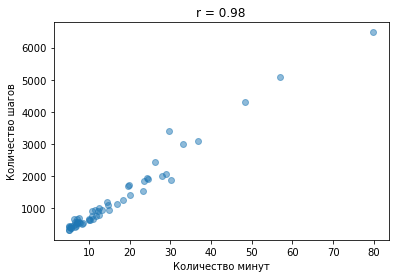

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(df['duration']/(60*np.timedelta64(1, 's')), df['steps'], alpha = 0.5)
corr = round(df['steps']. corr(df['duration']/(60*np.timedelta64(1, 's'))),2)
ax.set(xlabel = 'Количество минут', ylabel='Количество шагов',
      title = f'r = {corr}')

[Text(0.5, 0, 'Количество минут'),
 Text(0, 0.5, 'Скорость передвижения, шагов в мин.'),
 Text(0.5, 1.0, 'r = 0.26')]

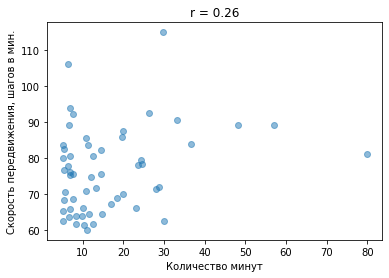

In [20]:
fig, ax = plt.subplots()
ax.scatter(df['duration']/(60*np.timedelta64(1, 's')), df['speed'], alpha = 0.5)
corr = round(df['speed']. corr(df['duration']/(60*np.timedelta64(1, 's'))),2)
ax.set(xlabel = 'Количество минут', ylabel='Скорость передвижения, шагов в мин.',
      title = f'r = {corr}')

[Text(0.5, 0, 'Скорость передвижения, шагов в мин.'),
 Text(0, 0.5, 'Количество шагов'),
 Text(0.5, 1.0, 'r = 0.4')]

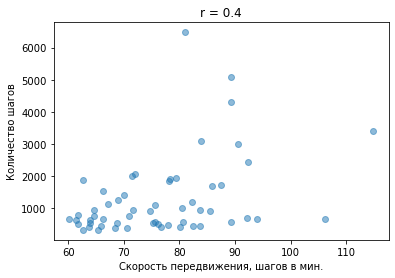

In [21]:
fig, ax = plt.subplots()
ax.scatter(df['speed'], df['steps'], alpha = 0.5)
corr = round(df['speed'].corr(df['steps']),2)
             
ax.set(xlabel = 'Скорость передвижения, шагов в мин.', ylabel='Количество шагов',
      title = f'r = {corr}')

Как видно из трех графиков выше между собой коррелируют только продолжительность шагов и время хотьбы (коэффициент корреляции r близок к 1). Действительно, эти два параметра интуитивно являются наиболее связанными. Скорость передвижения не должна зависить от ее продолжительности, т.к. человек может спешить куда-то недалеко и быстро добраться, а может долго бежать за уходящим автобусом. Также продолжительность хотьбы и скорость передвижения мало связаны, поскольку даже один и тот же путь в один и тот же день можно пройти очень быстро утром, опаздывая на работу, и очень медленно вечером, наслаждаясь окончанием рабочего дня.

# Функция для получения прогулок пользователя

Из шагов с обработкой данных сформируем требуемую функцию и запишем результат ее работы в файл walkings.json

In [22]:
from walkings import find_walkings

walkings = find_walkings(data)
with open('walkings.json', 'w') as outfile:
    json.dump(walkings, outfile)

7380it [00:37, 194.86it/s]


Проверим результаты работы:

In [23]:
with open('walkings.json', 'r') as f: 
    text = json.load(f) 

In [24]:
text['2022-04-05']

[{'start': '2022-04-05 13:32:18', 'end': '2022-04-05 13:37:22', 'steps': 331}]

In [25]:
text['2022-04-02']

[{'start': '2022-04-02 12:04:52', 'end': '2022-04-02 12:10:27', 'steps': 394},
 {'start': '2022-04-02 12:23:23', 'end': '2022-04-02 12:28:53', 'steps': 376},
 {'start': '2022-04-02 13:00:15', 'end': '2022-04-02 13:23:28', 'steps': 1539},
 {'start': '2022-04-02 16:45:38', 'end': '2022-04-02 16:52:28', 'steps': 450},
 {'start': '2022-04-02 21:19:11', 'end': '2022-04-02 21:29:58', 'steps': 922}]

Реализованная функция записывает прогулки в требуемом формате, проводя предварительно отбор данных согласно EDA